# MODELING

This notebook aims to fit a linear regression model to the cleaned King County housing data that is able to predict home prices beased on selected features. This notebook is based on insight from the EDA documented in the Data Cleaning Notebook, and Questions 1-3 Notebooks.

Model attempts to satisfy these assumptions: 

        1.	Features are linearly related to target
        2.	Residuals are normally distributed
        3.	Residuals have homoscedasticity
        4.	Features do not have multicollinearity

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.api as sms
import scipy.stats as stats
import matplotlib.pyplot as plt
import warnings
import itertools
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, r2_score
from sklearn.feature_selection import RFE
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
def build_sm_ols(df, features_to_use, target, add_constant=False, show_summary=True):
    """Takes in a Data Frame, list of features, and a target column name (string).
        Builds an OLS model and returns the summary table.
        Set add constant to 'True' if you want an intercept."""
    X = df[features_to_use]
    if add_constant:
        X = sm.add_constant(X)
    y = df[target]
    ols = sm.OLS(y, X).fit()
    if show_summary:
        print(ols.summary())
    return ols

def check_vif(df, features_to_use, target_feature):
    """Takes in a df, list of features, and returns VIF score"""
    ols = build_sm_ols(df=df, features_to_use=features_to_use, target=target_feature, show_summary=False)
    r2 = ols.rsquared
    return 1 / (1 - r2)

def check_vif_feature_space(df, features_to_use, vif_threshold=3.0):
    """Retrieves VIF score for all the features (without target) to compare for multicolinearity.
        Returns 'True' if threshold not passed, else returns the features and their VIF scores."""
    all_good_vif = True
    for feature in features_to_use:
        target_feature = feature
        _features_to_use = [f for f in features_to_use if f!=target_feature]
        vif = check_vif(df=df, features_to_use=_features_to_use, target_feature=target_feature)
        if vif >= vif_threshold:
            print(f"{target_feature} surpassed threshold with vif={vif}")
            all_good_vif = False
    return all_good_vif

def check_model(df, 
                features_to_use, 
                target_col, 
                add_constant=False, 
                show_summary=False, 
                vif_threshold=3.0):
    has_multicollinearity = check_vif_feature_space(df=df, 
                                                    features_to_use=features_to_use, 
                                                    vif_threshold=vif_threshold)
    if not has_multicollinearity:
        print("Model contains multicollinear features")
    
    # build model 
    ols = build_sm_ols(df=df, features_to_use=features_to_use, 
                       target=target_col, add_constant=add_constant, 
                       show_summary=show_summary)
    
    # check residuals
    resids_are_norm = check_residuals_normal(ols)
    resids_are_homo = check_residuals_homoskedasticity(ols)
    
    if not resids_are_norm or not resids_are_homo:
        print("Residuals failed test/tests")
    return ols

def check_residuals_normal(ols):
    """Check that residuals are normally distributed"""
    residuals = ols.resid
    t, p = stats.shapiro(residuals)
    if p <= 0.05:
        return False
    return True

def check_residuals_homoskedasticity(ols):
    """Check that residuals are homoskedasticitous """
    import statsmodels.stats.api as sms
    resid = ols.resid
    exog = ols.model.exog
    lg, p, f, fp = sms.het_breuschpagan(resid=resid, exog_het=exog)
    if p >= 0.05:
        return True
    return False

def norm_col(series):
    """Normalize a column by calculating the Z-score"""
    return (series - series.mean()) / series.std()

def plot_residuals(df, target, features, model):
    """Plots: 1) Scatter of y data values and y_hat predicted values from model. 
                Desire a 45 degree line corner to corner.
              2) Histogram of residual distriubtion. Desire a normal/bell distribution.
              3) Plot a check for homoskedasticity. Desire a uniform spread and not a cone shape.
              4) QQ plot check for normalcy. Desire a straight blue line at 45 degrees along red."""
    y_true = df[target]
    y_pred = model.predict(df[features])
    residuals = model.resid
    # 1
    plt.scatter(y_true, y_pred)
    plt.title('Predictions')
    plt.xlabel('y_true')
    plt.ylabel('y_predicted')
    plt.show()
    # 2
    plt.hist(residuals)
    plt.title('Distribution of Residuals')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.show()
    # 3
    x_axis = np.linspace(0,1,len(residuals))
    plt.scatter(x_axis, residuals)
    plt.hlines(y=0, xmin=0, xmax=1, color='red')
    plt.title('Check for Homoskedasticity')
    plt.ylabel('Residuals')
    plt.show()
    # 4
    fig = sm.graphics.qqplot(residuals, dist=stats.norm, line='45', fit=True)
    plt.title('QQ Plot for residuals')
    plt.show()
    
    return f"Mean residuals: $ {round(residuals.abs().mean(),2)}"

def get_train_test_RMSE(X, y):
    """Performs a Train/Test Split on df features (X) and target (y).
        Prints: the length of the split, the RMSE for test and train, whether the model might be 
        under or overfit, and the resulting coefficient of determination (R^2) for train and test set.
        Returns the 'linreg' obejct for use outside of function."""
    # train/test split at 70/30
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    print("Train/Test Split Lengths:", len(X_train), len(X_test), len(y_train), len(y_test))
    # fit model
    linreg = LinearRegression()
    linreg.fit(X_train, y_train)
    y_hat_train = linreg.predict(X_train)
    y_hat_test = linreg.predict(X_test) 
    # calculate the MSE for training and test sets:
    train_mse = mean_squared_error(y_train, y_hat_train)
    test_mse = mean_squared_error(y_test, y_hat_test)
    train_Rmse = round(np.sqrt(train_mse),2)
    test_Rmse = round(np.sqrt(test_mse),2)
    print('Train RMSE: $', train_Rmse)
    print('Test RMSE: $', test_Rmse)
    if test_mse > train_mse:
        print(f"Test RMSE is greater by {round(test_Rmse-train_Rmse,2)}, examine model for underfitting \n")
    else:
        print(f"Train RMSE is greater by {round(train_Rmse-test_Rmse,2)}, examine model for overfitting \n")
    print('Train Data R^2:', r2_score(y_train, linreg.predict(X_train)))
    print('Test DataR^2:', r2_score(y_test, linreg.predict(X_test)))
    return linreg

def cross_val(linreg, X, y, cv=5):
    """Takes in a linreg obj, feature df and target series.
        Performs a K-fold cross validation. Prints the mean RMSE and the number of folds.
        Returns the individual results as an np.array."""
    mse = make_scorer(mean_squared_error)
    cv_5_results = cross_val_score(linreg, X, y, cv=5, scoring=mse)
    print("Cross Val. Mean: $", round(np.sqrt(cv_5_results.mean()),2), "Folds:", cv)
    return cv_5_results


In [3]:
# refresh on what the cleaned data contains
df = pd.read_csv("../data/kc_house_data_cleaned.csv").drop('Unnamed: 0', axis=1)
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'has_basement', 'sqft_living',
       'sqft_lot', 'liv/lot', 'view', 'age', 'age_decade', 'condition',
       'grade', 'reno?', 'reno_age', 'lat', 'long', 'zipcode',
       'zipcode_mean_price', 'zipcode_median_price', 'zipcode_mode_price',
       'zip_rank_price', 'zipcode_mean_lot', 'zipcode_mean_liv',
       'pop_den_by_zip'],
      dtype='object')

In [4]:
df.describe().apply(lambda s: s.apply(lambda x: round(x, 2)))

,price,bedrooms,bathrooms,has_basement,sqft_living,sqft_lot,liv/lot,view,age,age_decade,...,lat,long,zipcode,zipcode_mean_price,zipcode_median_price,zipcode_mode_price,zip_rank_price,zipcode_mean_lot,zipcode_mean_liv,pop_den_by_zip
count,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,...,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00,20287.00
mean,495432.02,3.35,2.07,0.38,1995.61,9233.06,0.33,0.19,44.42,3.98,...,47.56,-122.22,98079.60,495432.02,464778.03,453325.90,2.50,9233.06,1995.61,4403.75
std,243214.88,0.89,0.73,0.49,800.03,8082.44,0.27,0.68,29.45,2.94,...,0.14,0.14,53.76,169787.31,161308.27,205794.63,1.17,4205.77,338.69,2928.69
min,78000.00,1.00,0.50,0.00,370.00,520.00,0.01,0.00,0.00,0.00,...,47.16,-122.51,98001.00,234284.04,235000.00,210000.00,1.00,3015.20,1468.62,41.00
25%,315000.00,3.00,1.50,0.00,1400.00,5000.00,0.16,0.00,19.00,1.00,...,47.47,-122.33,98033.00,345204.02,330000.00,290000.00,1.00,5583.80,1735.14,2215.00
50%,440000.00,3.00,2.25,0.00,1870.00,7410.00,0.25,0.00,41.00,4.00,...,47.57,-122.24,98072.00,483233.17,440000.00,400000.00,2.00,9468.32,1951.42,4161.00
75%,619000.00,4.00,2.50,1.00,2460.00,10000.00,0.41,0.00,64.00,6.00,...,47.68,-122.13,98118.00,604844.74,564000.00,550000.00,3.00,11323.03,2209.22,6425.00
max,1450000.00,10.00,7.50,1.00,7480.00,54557.00,4.65,4.00,115.00,11.00,...,47.78,-121.31,98199.00,1145666.67,1200000.00,1200000.00,5.00,31219.29,2998.80,15829.00


In [5]:
# drop columns that contain $$$ value
# target = 'price' in calculation; would be too much bias
# zip_rank_price is 1-5 ranking of median price per zip but does not contain actual dollar amount so leaving it in
df.drop(['zipcode_mean_price',
 'zipcode_median_price',
 'zipcode_mode_price'], axis=1, inplace=True)

In [6]:
# calculate a rough score representing distance from center (most expensive area, Bellevue)
# to compare how it fares in the model vs. actual long/lat
top_lat = df.loc[df['price'] == 1450000][['lat', 'long']].mean()[0]
top_long = df.loc[df['price'] == 1450000][['lat', 'long']].mean()[1]

df['dist_cent'] = abs((df['lat'] - top_lat) * (df['long'] - top_long))
# drop 55 homes determined to be too far from center in "Where?" notebook
df = df.loc[df['dist_cent']<0.1] 

### Correlation

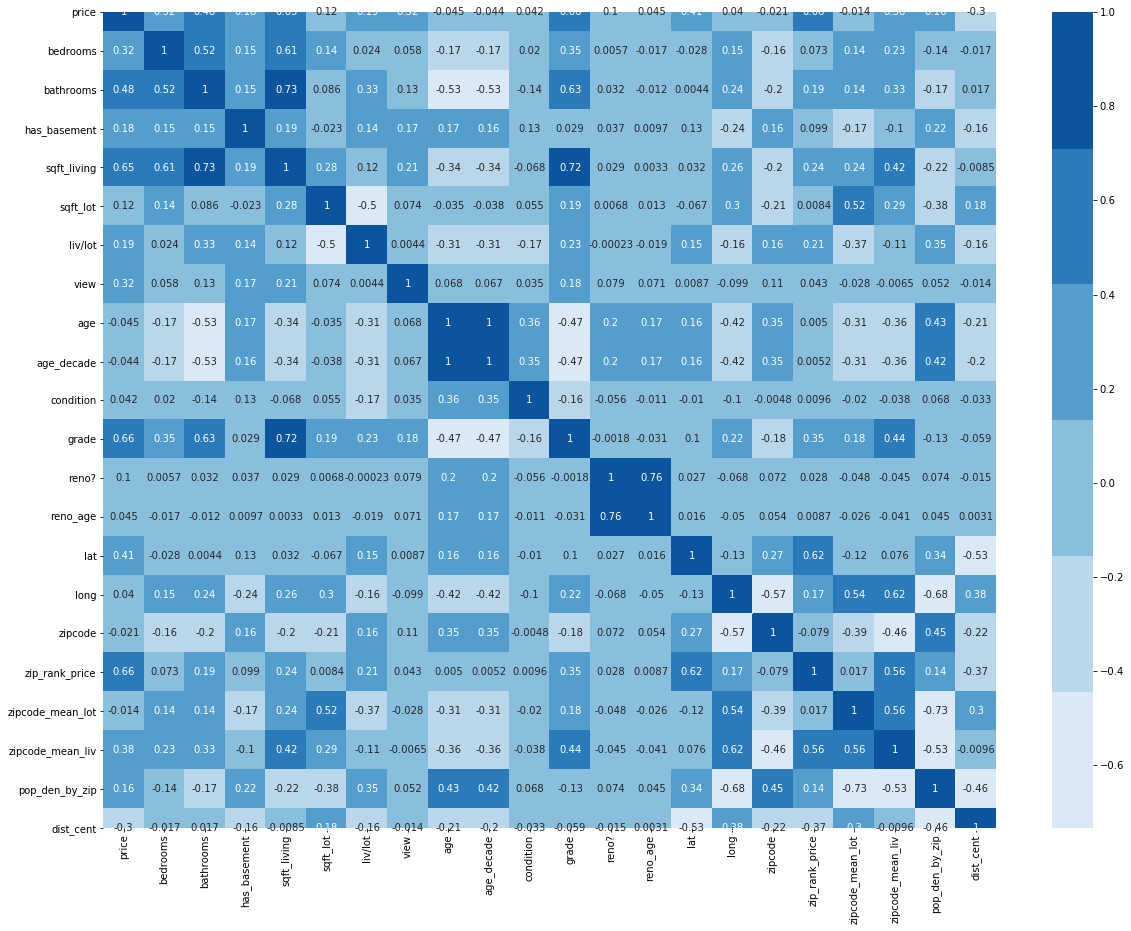

In [7]:
# examine correlation of all features, quick overview for multi-colinearity
plt.figure(figsize=(20,15))
sns.heatmap(df.corr(), annot=True, cmap=sns.color_palette('Blues'), fmt='0.2g');

In [8]:
# calculate correlation with target, home sale 'price'
# which features will be the best predictors?
target = 'price'
correlation_array = []
failed_cols = []
for col in df.drop(target,axis=1).columns:
    try:
        correlation = abs(np.corrcoef(df[col], df[target])[0][1])
        if correlation == correlation:
            correlation_array.append((col, correlation))
        else:
            failed_cols.append(col)
    except:
        failed_cols.append(col)
correlated_features = list(map(lambda x: x[0], correlation_array))
correlation_array = sorted(correlation_array, key=lambda x: x[1], reverse=True)
correlation_array

[('zip_rank_price', 0.6648347844504322),
 ('grade', 0.6562417600561955),
 ('sqft_living', 0.6467980677313286),
 ('bathrooms', 0.475990550397925),
 ('lat', 0.4075651759358827),
 ('zipcode_mean_liv', 0.37647975406021916),
 ('view', 0.31684459562499634),
 ('bedrooms', 0.3167008792999216),
 ('dist_cent', 0.30204140110145206),
 ('liv/lot', 0.1932293148446673),
 ('has_basement', 0.18472517563137994),
 ('pop_den_by_zip', 0.15767140873751592),
 ('sqft_lot', 0.12127270772910517),
 ('reno?', 0.10025550353501664),
 ('reno_age', 0.04542922887573871),
 ('age', 0.0454022863866378),
 ('age_decade', 0.044234317077923836),
 ('condition', 0.042010549126438576),
 ('long', 0.040189294768764997),
 ('zipcode', 0.020540609089422877),
 ('zipcode_mean_lot', 0.014128794480145488)]

In [9]:
# select top 13 correlated features (choosing to examine those with corr. coef. above 0.1)
top_13_corr = list(map(lambda x: x[0], correlation_array[:13]))
top_13_corr

['zip_rank_price',
 'grade',
 'sqft_living',
 'bathrooms',
 'lat',
 'zipcode_mean_liv',
 'view',
 'bedrooms',
 'dist_cent',
 'liv/lot',
 'has_basement',
 'pop_den_by_zip',
 'sqft_lot']

In [10]:
# how are these features correlated with each other?
df_corr=df[top_13_corr].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr['pairs'] = list(zip(df_corr.level_0, df_corr.level_1))
df_corr.set_index(['pairs'], inplace = True)
df_corr.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr.columns = ['cc']
# drop duplicates 
df_corr.drop_duplicates(inplace=True)
# select range considered "highly correlated" to examine
df_corr[(abs(df_corr.cc)>.5) & (abs(df_corr.cc) <1)]

,cc
pairs,
"(bathrooms, sqft_living)",0.727255
"(grade, sqft_living)",0.724521
"(bathrooms, grade)",0.628427
"(lat, zip_rank_price)",0.622107
"(sqft_living, bedrooms)",0.611599
"(zipcode_mean_liv, zip_rank_price)",0.561868
"(pop_den_by_zip, zipcode_mean_liv)",0.529727
"(dist_cent, lat)",0.529057
"(bedrooms, bathrooms)",0.515845


In [11]:
# bathrooms, bedrooms deleted; represented by grade and sq_ft living
to_remove = ['bathrooms', 'bedrooms']
df.drop(to_remove, axis=1, inplace=True)
top_11_corr = list(set(top_13_corr).difference(to_remove))

In [12]:
# this ratio is less correlated with price than its origin columns
to_remove = ['liv/lot']
df.drop(to_remove, axis=1, inplace=True)
top_10_corr = list(set(top_11_corr).difference(to_remove))

In [13]:
# reduced to top 10 correlated features (with price)
top_10_df = df[top_10_corr+['price']]
top_10_df.to_csv("../data/top_10_df.csv")
top_10_corr

['zip_rank_price',
 'dist_cent',
 'zipcode_mean_liv',
 'sqft_living',
 'sqft_lot',
 'pop_den_by_zip',
 'view',
 'grade',
 'has_basement',
 'lat']

In [14]:
# top_10_df = pd.read_csv("../data/top_10_df.csv").drop('Unnamed: 0', axis=1)

### Distributions

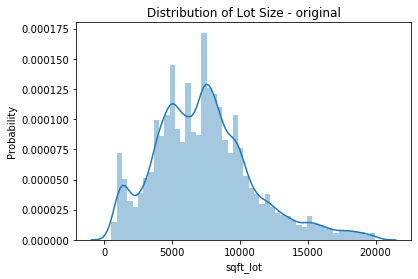

In [15]:
# based on "Where?" investigatiton notebook,
# previous lot distribution by zip, the areas we are interested are below 25,000 sq ft lots
# and closer to city center
top_10_df = top_10_df.loc[top_10_df['sqft_lot'] < 20000]
sns.distplot(top_10_df['sqft_lot']);
plt.title('Distribution of Lot Size - original')
plt.ylabel('Probability')
plt.show()

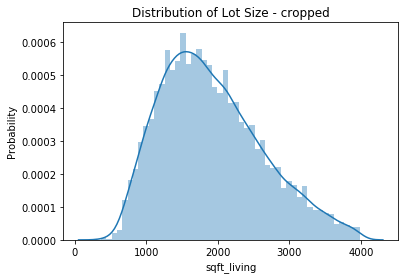

In [16]:
# based on our "Where?" investigation, the areas we are interested in average houses below 
# 4,000 sq ft living space
top_10_df = top_10_df.loc[top_10_df['sqft_living'] < 4000]
sns.distplot(top_10_df['sqft_living']);
plt.title('Distribution of Lot Size - cropped')
plt.ylabel('Probability')
plt.show()

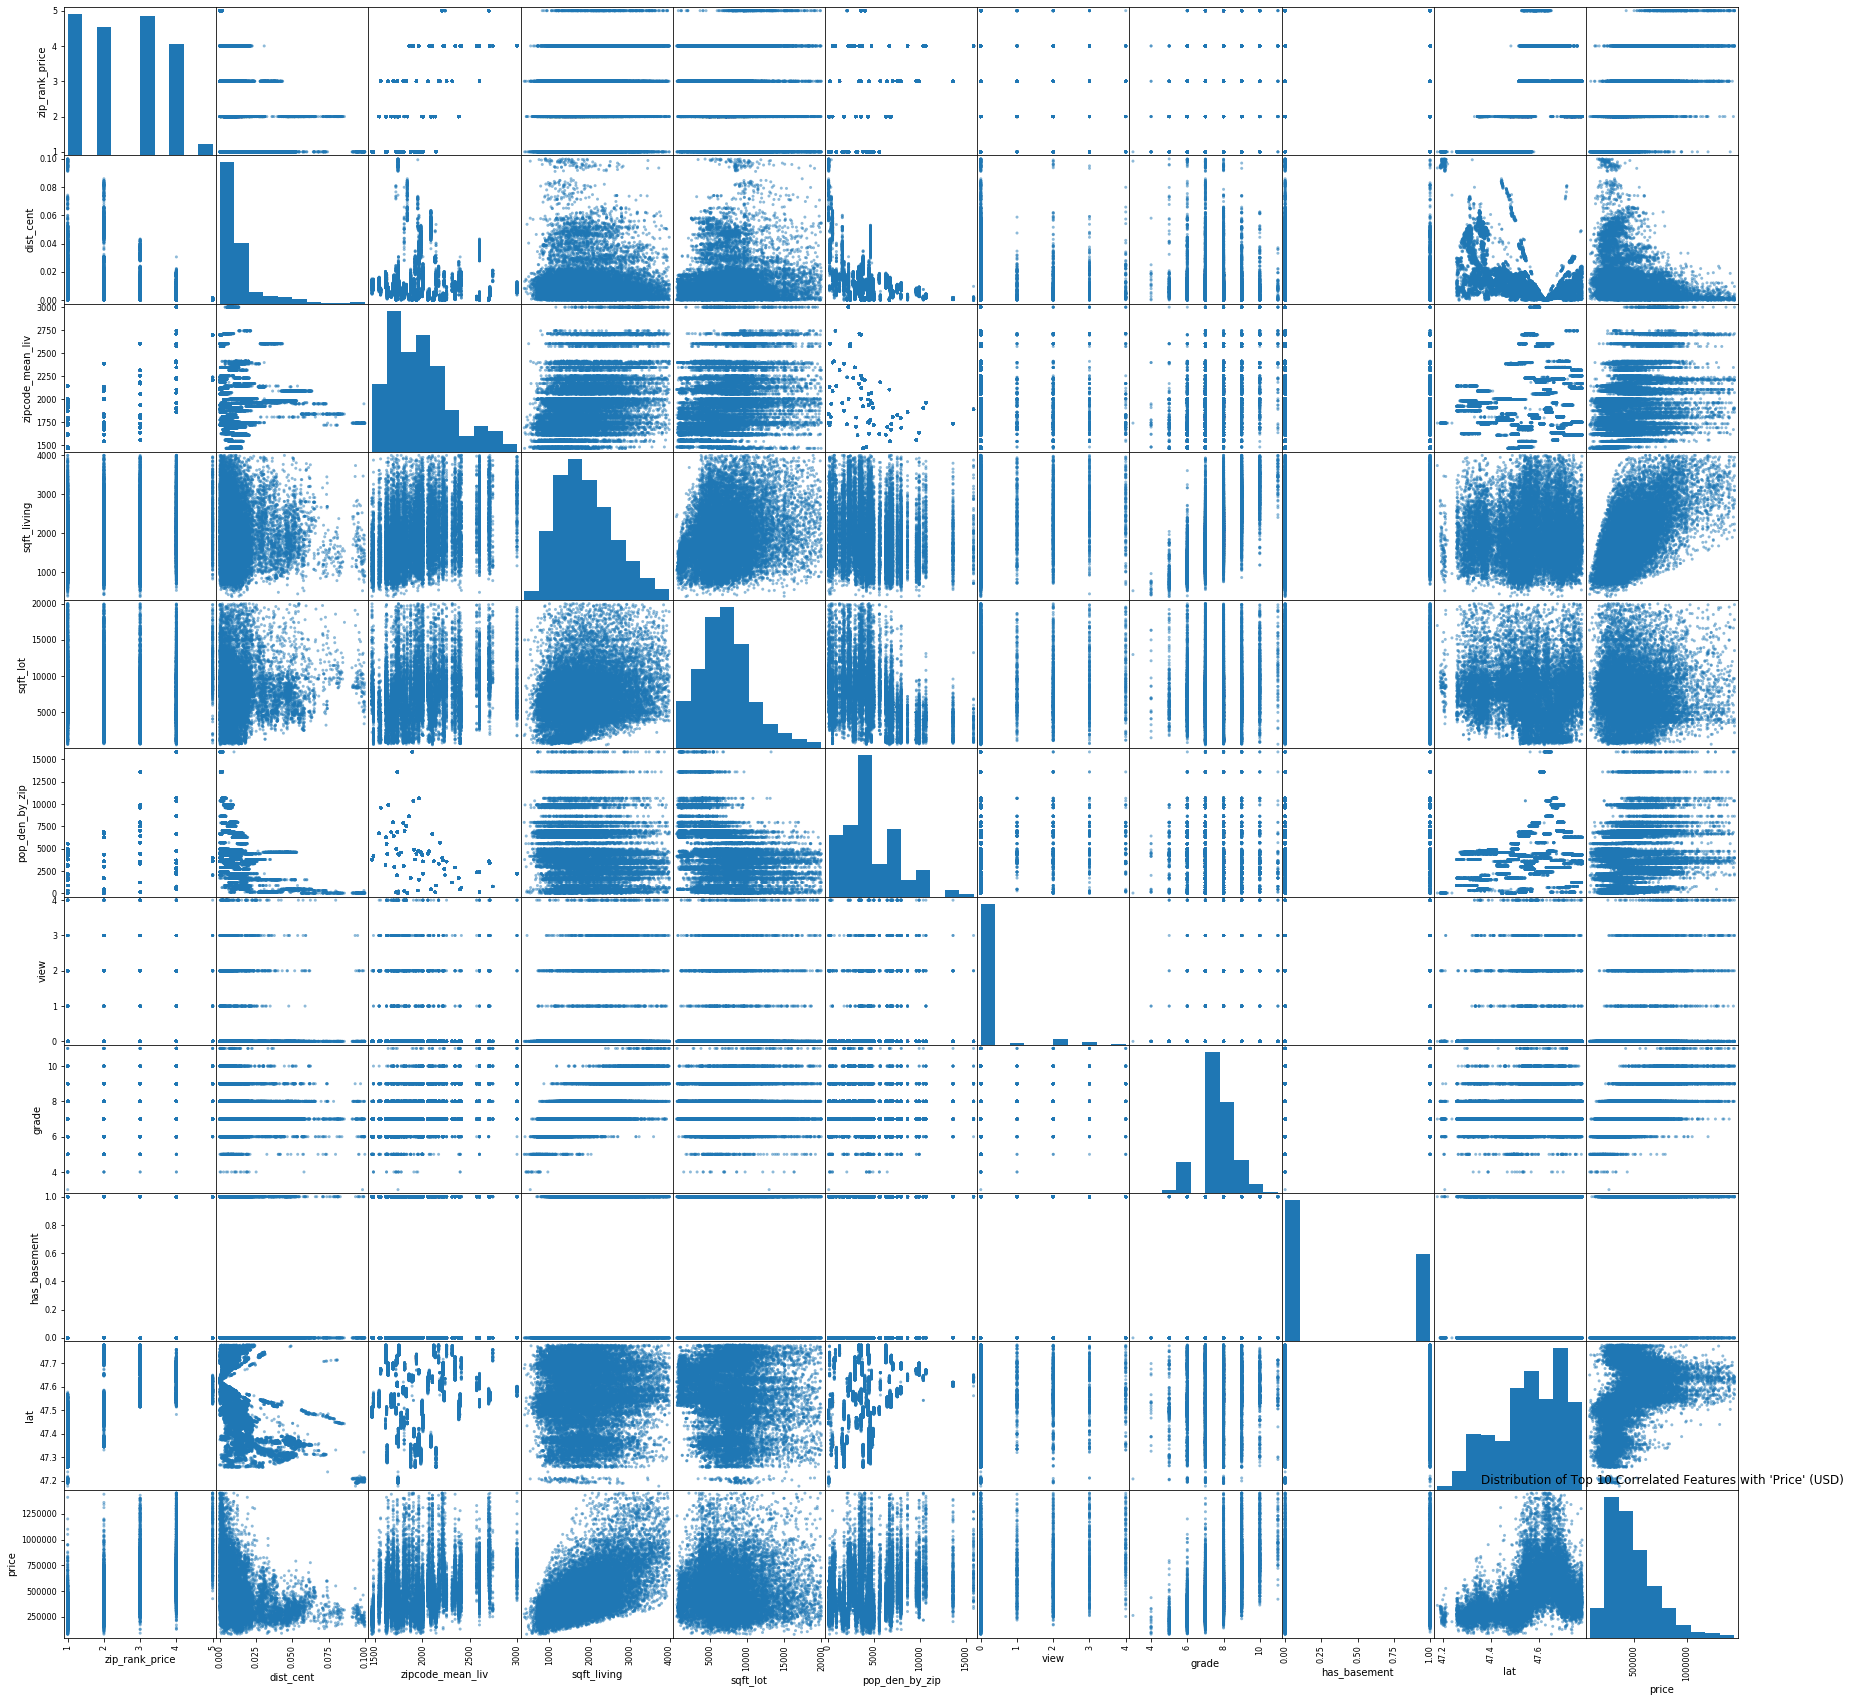

In [17]:
# examine distribution of remaining/subset feature space
pd.plotting.scatter_matrix(top_10_df, figsize=(30, 30));
plt.title("Distribution of Top 10 Correlated Features with 'Price' (USD)")
plt.show()

Strategy for processing:
- 'has_basement' to be treated as a single col bool
- 'lat' to be left untreated as its a descriptor
- 'view', 'zip_rank', 'zip_mean_liv', 'pop_density', 'grade' could all be classified as categorical. 

For the first series of trials, will experiement with running them as numeric to examine 
if there exists a weighted effect on ranking

### Log Transform

In [18]:
# continuous columns to normalize:
cols_to_log = ['dist_cent', 'sqft_lot', 'sqft_living']

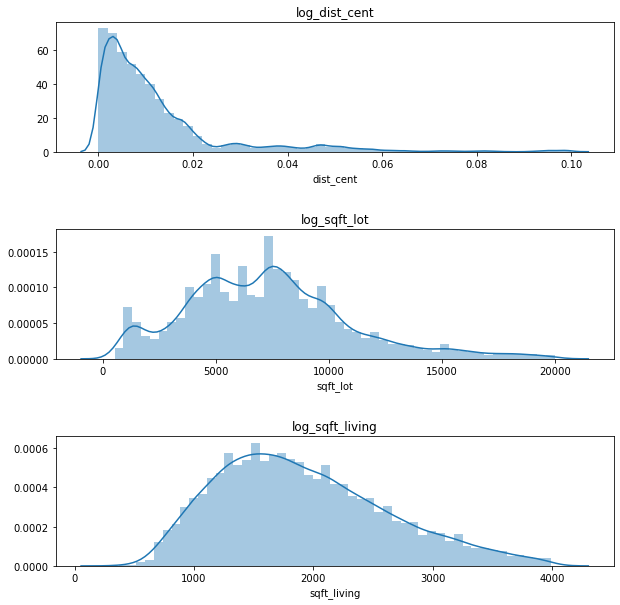

In [19]:
# perform log transformation and re-examine distribution:
fig, axes = plt.subplots(nrows=len(cols_to_log), ncols=1, figsize=(10,10))
for column, ax in zip(cols_to_log, axes.flatten()):
    top_10_df[column].map(lambda x: np.log(x))
    sns.distplot(top_10_df[column], label=f"log_{column}", ax=ax)
    top_10_df.rename({column: (f"log_"+column)}, axis=1, inplace=True)
    plt.subplots_adjust(wspace=0.2, hspace=0.6)
    ax.set_title((f"log_"+column))

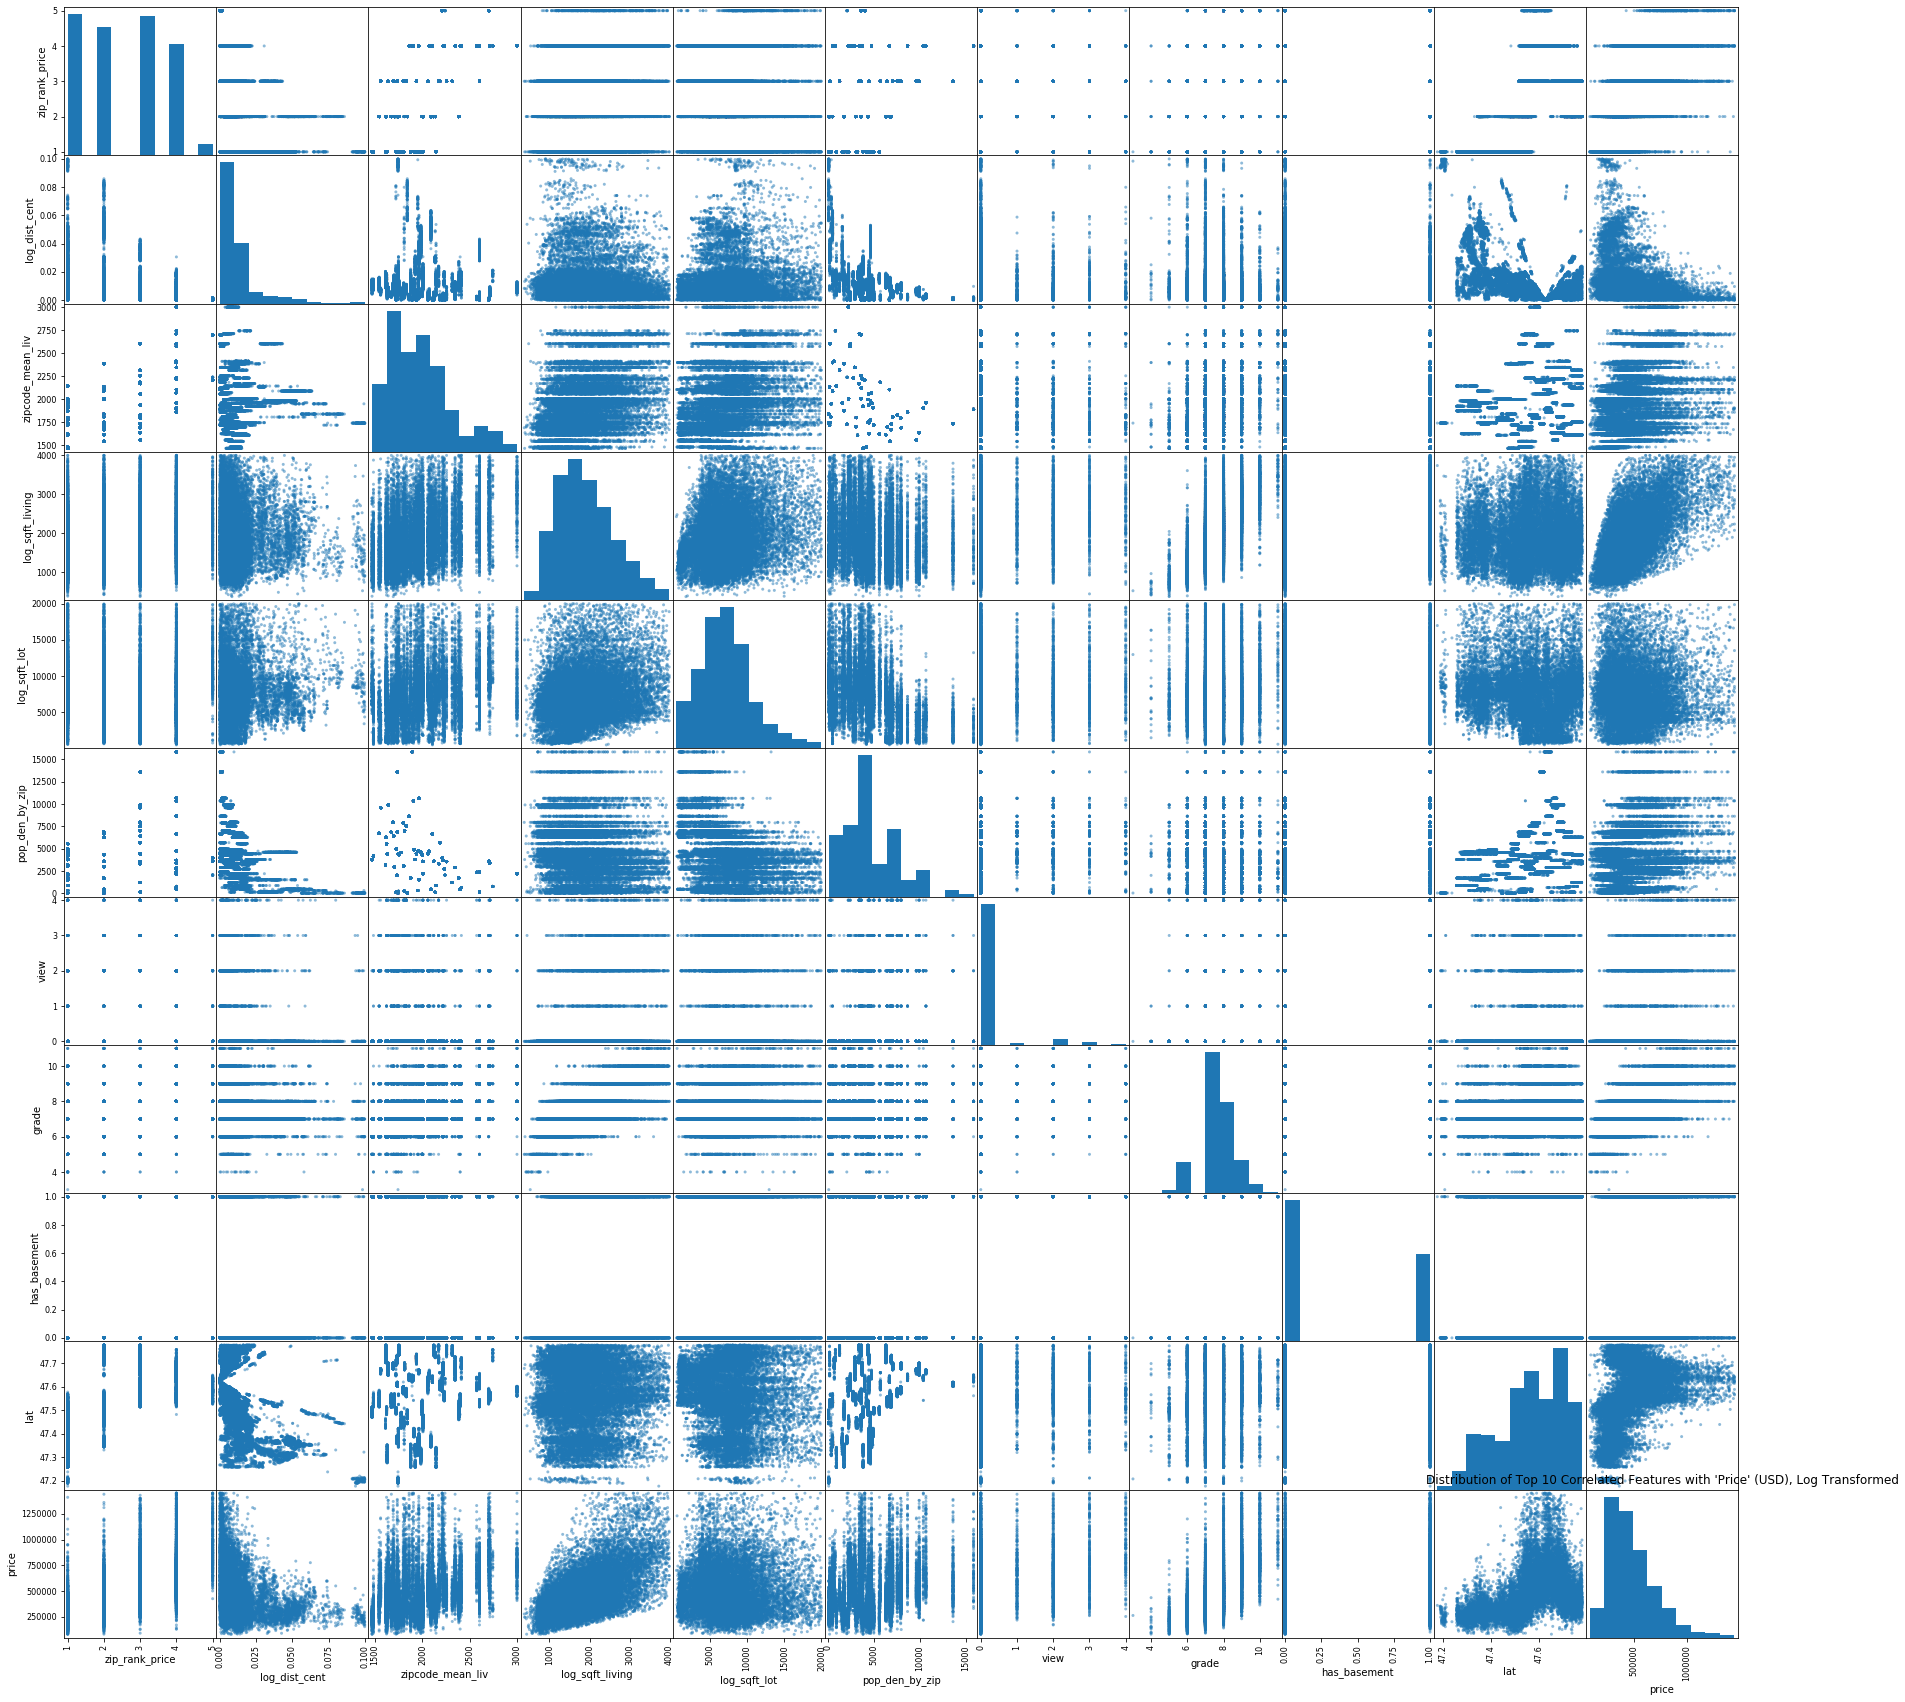

In [20]:
pd.plotting.scatter_matrix(top_10_df, figsize=(30, 30));
plt.title("Distribution of Top 10 Correlated Features with 'Price' (USD), Log Transformed")
plt.show()

### Standardize

#### For Series 1: 
Treating categorical columns as continuous, because there is a believed weight to the values. Series 1 uses 'df1' going forward to keep 'top_10_df' same incase I need to re-access it without modifications.

In [21]:
df1 = top_10_df
df1.describe().apply(lambda s: s.apply(lambda x: round(x, 2)))

,zip_rank_price,log_dist_cent,zipcode_mean_liv,log_sqft_living,log_sqft_lot,pop_den_by_zip,view,grade,has_basement,lat,price
count,18556.00,18556.00,18556.00,18556.00,18556.00,18556.0,18556.00,18556.00,18556.00,18556.00,18556.00
mean,2.48,0.01,1973.36,1914.84,7320.20,4619.3,0.17,7.49,0.38,47.56,480352.62
std,1.15,0.01,326.37,708.19,3637.10,2922.0,0.64,0.99,0.49,0.14,229720.01
min,1.00,0.00,1468.62,370.00,520.00,41.0,0.00,3.00,0.00,47.18,78000.00
25%,1.00,0.00,1729.97,1380.00,4817.50,2642.0,0.00,7.00,0.00,47.48,310000.00
50%,2.00,0.01,1937.39,1820.00,7200.00,4330.0,0.00,7.00,0.00,47.57,430000.00
75%,3.00,0.01,2144.05,2370.00,9315.25,6732.0,0.00,8.00,1.00,47.68,599410.00
max,5.00,0.10,2998.80,3990.00,19998.00,15829.0,4.00,11.00,1.00,47.78,1450000.00


In [22]:
features1 = list(df1.columns)[:-1] # pop off last item, target = 'price'
features1

['zip_rank_price',
 'log_dist_cent',
 'zipcode_mean_liv',
 'log_sqft_living',
 'log_sqft_lot',
 'pop_den_by_zip',
 'view',
 'grade',
 'has_basement',
 'lat']

In [23]:
cols_to_stnrd = ['view',
 'zipcode_mean_liv',
 'log_dist_cent',
 'grade',
 'log_sqft_living',
 'lat',
 'log_sqft_lot',
 'pop_den_by_zip']

for column in cols_to_stnrd:
    df1[column] = norm_col(df1[column])

df1.head()

,zip_rank_price,log_dist_cent,zipcode_mean_liv,log_sqft_living,log_sqft_lot,pop_den_by_zip,view,grade,has_basement,lat,price
0,1,-0.642385,-0.768268,-1.037627,-0.459213,0.118651,-0.267061,-0.493634,0,-0.370912,221900.0
1,2,-0.264876,-0.729294,0.925119,-0.021501,0.773340,-0.267061,-0.493634,1,1.164594,538000.0
2,2,-0.829605,0.448536,-1.616567,0.736795,-0.346784,-0.267061,-1.503655,0,1.288283,180000.0
3,3,0.311391,-0.839873,0.063770,-0.637927,0.617967,-0.267061,-0.493634,1,-0.300651,604000.0
4,4,-0.741604,1.929180,-0.331603,0.208902,-0.755751,-0.267061,0.516386,0,0.401964,510000.0


In [24]:
# repeat correlation check
# how are these features correlated with each other?
df_corr2=df1[features1].corr().abs().stack().reset_index().sort_values(0, ascending=False)
df_corr2['pairs'] = list(zip(df_corr2.level_0, df_corr2.level_1))
df_corr2.set_index(['pairs'], inplace = True)
df_corr2.drop(columns=['level_1', 'level_0'], inplace = True)
df_corr2.columns = ['cc']
df_corr2.drop_duplicates(inplace=True)
# adjust new table as needed
df_corr2[(abs(df_corr2.cc)>.5) & (abs(df_corr2.cc) <1)]

,cc
pairs,
"(log_sqft_living, grade)",0.685662
"(lat, zip_rank_price)",0.622872
"(zipcode_mean_liv, zip_rank_price)",0.538200
"(log_dist_cent, lat)",0.535703
"(pop_den_by_zip, zipcode_mean_liv)",0.526979


Grade and sqft_living are highly correlated. Let's try two seperate feature spaces for each. 'lat' information is represented both in zip_mean_rank and log_dist_center. Lets try dropping it for both. Choosing to proceed without an intercept for these reasons: if all these features are 0, will there be a house remaining to sell? My since zipcode and lot data are the base for a home (none of the data includes apartments or homes not on lots), if a lot does not exist or the home is in a zipcode not accounted for in our model, there exists no predictive power and home price will be Null.

## Build Models

### Series 1: Grade

#### Trial 1

In [25]:
# feature space without 'sqft_living'
grade_features1 = list(set(features1).difference(['log_sqft_living', 'lat']))
grade_features1

['zip_rank_price',
 'zipcode_mean_liv',
 'log_sqft_lot',
 'has_basement',
 'pop_den_by_zip',
 'grade',
 'log_dist_cent',
 'view']

In [26]:
# check VIF scores for features to check for multi-colinearity
# VIF threshold for this function to pass: scores above 3 yield a False
check_vif_feature_space(df1, grade_features1)

True

In [27]:
# features pass the VIF check, assess model scores
model1 = build_sm_ols(df1, grade_features1, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.937
Model:                            OLS   Adj. R-squared (uncentered):              0.937
Method:                 Least Squares   F-statistic:                          3.425e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:30:31   Log-Likelihood:                     -2.4540e+05
No. Observations:               18556   AIC:                                  4.908e+05
Df Residuals:                   18548   BIC:                                  4.909e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

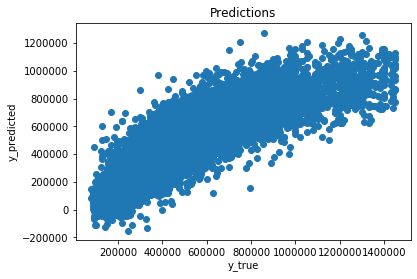

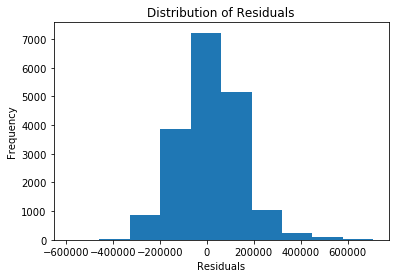

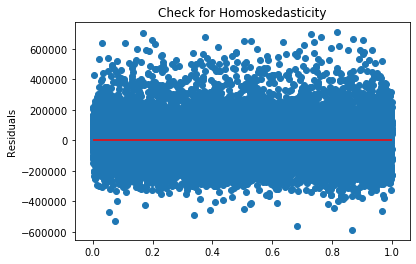

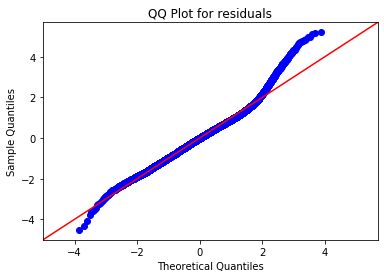

'Mean residuals: $ 103453.23'

In [28]:
# P-values are all less than 0.05, keep all features
# residuals shows some skew based on scores, let's examine visually
plot_residuals(df1, target, grade_features1, model1)

Model 1 passes test for multi-colinearity but does not pass assumptions about the normalacy of residuals. The error is quite large also, average ability tot predict target within $103,453.23. That is half the price of a house. This model is not very useful.

#### Trial 5 (out of order)

In [29]:
# let's remove the top percentile of home price zips to see if we can reduce the skew.
df2 = df1.loc[df1['price']<1250000]
len(df1) - len(df2) # cut 391 records
df2['price'].max()

1240000.0

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.940
Model:                            OLS   Adj. R-squared (uncentered):              0.940
Method:                 Least Squares   F-statistic:                          3.604e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:30:32   Log-Likelihood:                     -2.4142e+05
No. Observations:               18340   AIC:                                  4.828e+05
Df Residuals:                   18332   BIC:                                  4.829e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

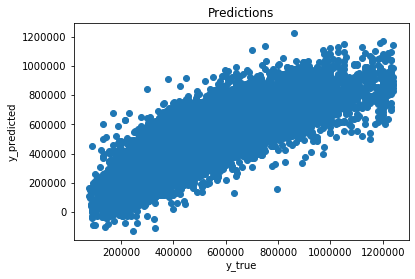

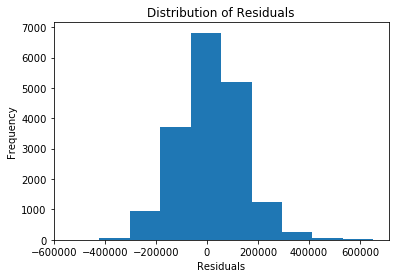

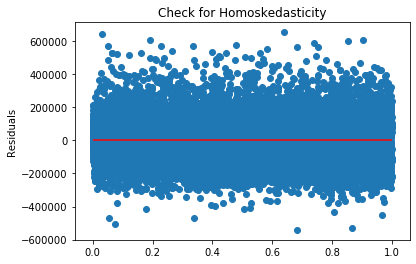

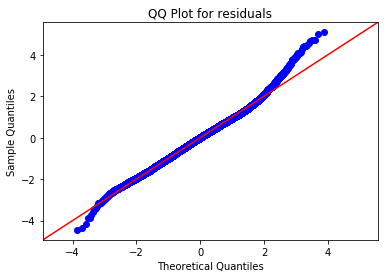

'Mean residuals: $ 98850.22'

In [30]:
check_vif_feature_space(df2, grade_features1)
model5 = build_sm_ols(df2, grade_features1, target, add_constant=False, show_summary=True)
plot_residuals(df2, target, grade_features1, model5)

### Series 2: Sq Ft Living
#### Trial 2

In [31]:
# feature space without 'grade'
sqliv_features1 = list(set(features1).difference(['grade', 'lat']))
sqliv_features1

['zip_rank_price',
 'zipcode_mean_liv',
 'log_sqft_living',
 'log_sqft_lot',
 'has_basement',
 'pop_den_by_zip',
 'log_dist_cent',
 'view']

In [32]:
check_vif_feature_space(df1, sqliv_features1)

True

In [33]:
model2 = build_sm_ols(df1, sqliv_features1, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.947
Model:                            OLS   Adj. R-squared (uncentered):              0.947
Method:                 Least Squares   F-statistic:                          4.125e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:30:33   Log-Likelihood:                     -2.4378e+05
No. Observations:               18556   AIC:                                  4.876e+05
Df Residuals:                   18548   BIC:                                  4.876e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------

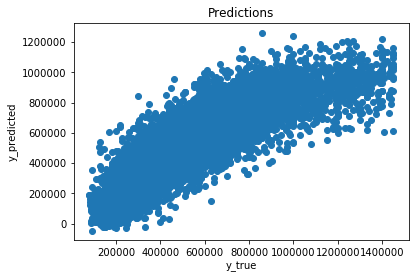

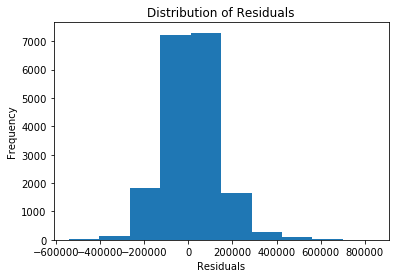

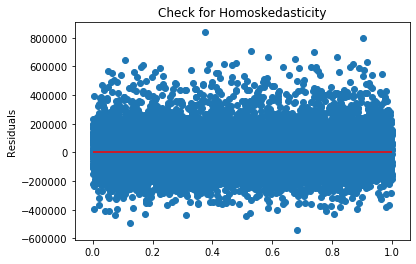

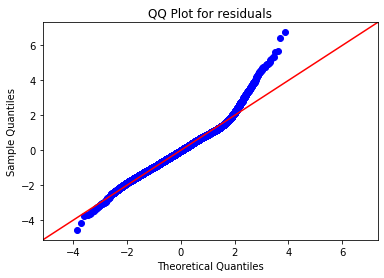

'Mean residuals: $ 94189.32'

In [34]:
plot_residuals(df1, target, sqliv_features1, model2)

Mean residuals slightly less, however distribution of errors much more peaky. 
#### Trial 3

In [35]:
sqliv_features2 = list(set(sqliv_features1).difference(['zipcode_mean_liv']))
check_vif_feature_space(df1, sqliv_features2)

True

In [36]:
model3 = build_sm_ols(df1, sqliv_features2, target, add_constant=False, show_summary=True)

                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.932
Model:                            OLS   Adj. R-squared (uncentered):              0.932
Method:                 Least Squares   F-statistic:                          3.620e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:30:34   Log-Likelihood:                     -2.4608e+05
No. Observations:               18556   AIC:                                  4.922e+05
Df Residuals:                   18549   BIC:                                  4.922e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------

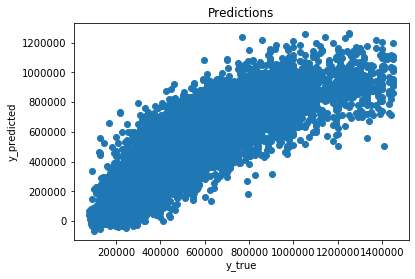

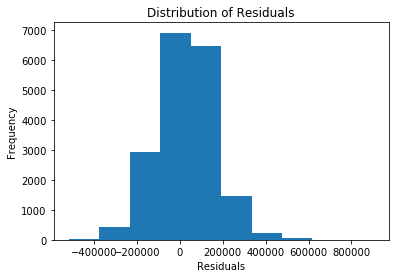

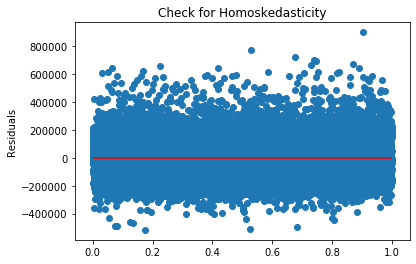

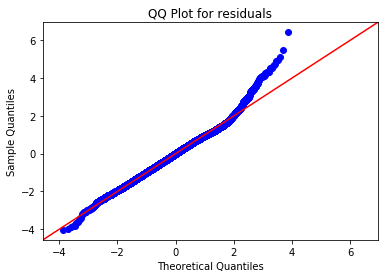

'Mean residuals: $ 109452.29'

In [37]:
plot_residuals(df1, target, sqliv_features2, model3)

Mean residuals went up. Skew to the resdiuals distribution, but the lowest skews so far. There are high-end outliers throwing this off.

#### Trial 4

Repeat above but with 'df2'

VIF CHECK: True
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.935
Model:                            OLS   Adj. R-squared (uncentered):              0.935
Method:                 Least Squares   F-statistic:                          3.749e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:30:36   Log-Likelihood:                     -2.4223e+05
No. Observations:               18340   AIC:                                  4.845e+05
Df Residuals:                   18333   BIC:                                  4.845e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

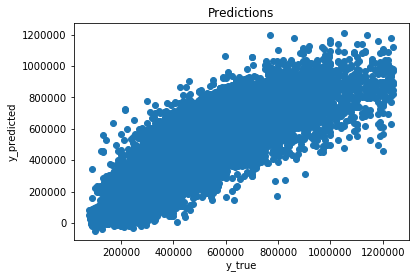

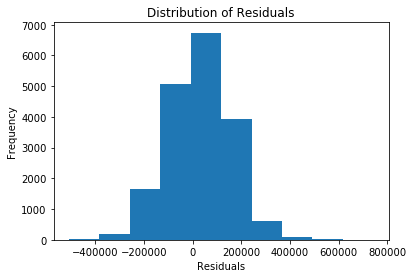

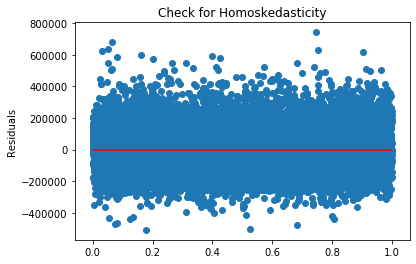

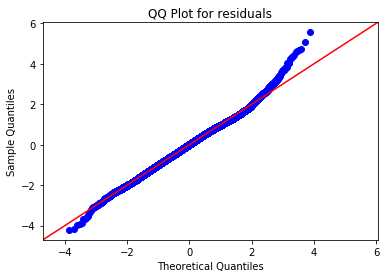

'Mean residuals: $ 105081.27'

In [38]:
print("VIF CHECK:", check_vif_feature_space(df2, sqliv_features2))
model4 = build_sm_ols(df2, sqliv_features2, target, add_constant=False, show_summary=True)
plot_residuals(df2, target, sqliv_features2, model4)

### Trial 6

Reducing the span of prices seems to help with outliers, let's subset a bit more.

In [39]:
# let's remove the top percentile of home price zips to see if we can reduce the skew.
df3 = df1.loc[df1['price']<=1000000]
print(len(df2) - len(df3)) # cut number of records
df3['price'].max() # new max

363


1000000.0

VIF CHECK: True
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.936
Model:                            OLS   Adj. R-squared (uncentered):              0.936
Method:                 Least Squares   F-statistic:                          3.738e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:30:37   Log-Likelihood:                     -2.3659e+05
No. Observations:               17977   AIC:                                  4.732e+05
Df Residuals:                   17970   BIC:                                  4.732e+05
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                      coef    std err          t      P>|t|      [0.025      0.975]
--------------------

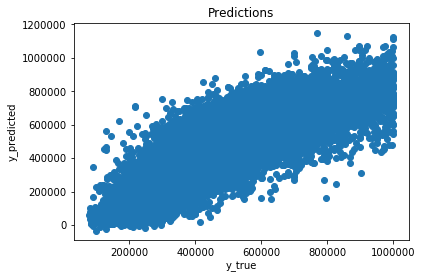

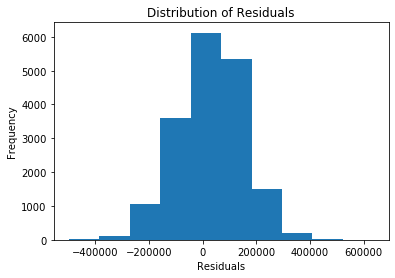

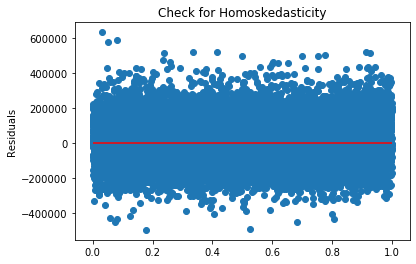

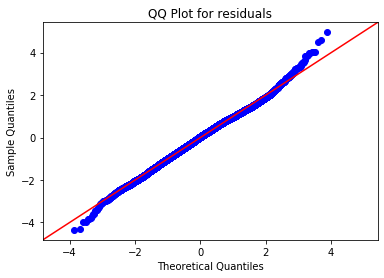

'Mean residuals: $ 101070.89'

In [40]:
print("VIF CHECK:", check_vif_feature_space(df3, sqliv_features2))
model6 = build_sm_ols(df3, sqliv_features2, target, add_constant=False, show_summary=True)
plot_residuals(df3, target, sqliv_features2, model6)

### Trial 7:

Using 'grade' again with new 'df3', max price $1,000,000.

VIF CHECK: True
                                 OLS Regression Results                                
Dep. Variable:                  price   R-squared (uncentered):                   0.943
Model:                            OLS   Adj. R-squared (uncentered):              0.943
Method:                 Least Squares   F-statistic:                          3.691e+04
Date:                Mon, 19 Oct 2020   Prob (F-statistic):                        0.00
Time:                        18:33:53   Log-Likelihood:                     -2.3557e+05
No. Observations:               17977   AIC:                                  4.712e+05
Df Residuals:                   17969   BIC:                                  4.712e+05
Df Model:                           8                                                  
Covariance Type:            nonrobust                                                  
                       coef    std err          t      P>|t|      [0.025      0.975]
-------------------

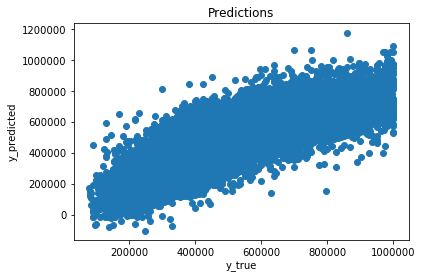

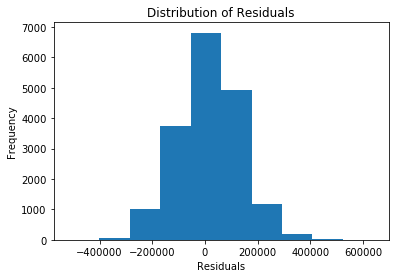

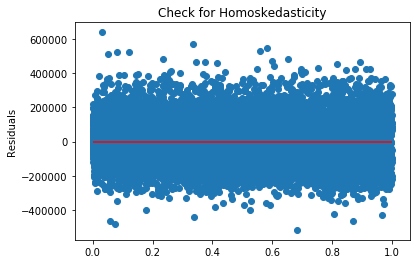

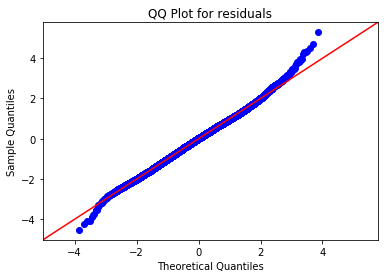

'Mean residuals: $ 94256.21'

In [42]:
print("VIF CHECK:", check_vif_feature_space(df3, grade_features1))
model7 = build_sm_ols(df3, grade_features1, target, add_constant=False, show_summary=True)
plot_residuals(df3, target, grade_features1, model7)

In [43]:
# test residuals mathmatically for Model 6
check_residuals_normal(model6), check_residuals_homoskedasticity(model6)

(False, False)

In [44]:
# test residuals mathmatically for Model 7
check_residuals_normal(model7), check_residuals_homoskedasticity(model7)

(False, False)

### Fit Model

#### Train/Test Split

Selected Model 6 and 7 to compare. It seems reducing to max price to $1,000,000 gave the best performance. Neither model could satisfy the assumption about normal residuals, but these were the ones with least amount of skew. Let's compare how they perform in train/test split.


#### Model 7: best of Grade series

In [45]:
selected_feat = grade_features1
X = df3[selected_feat]
y = df3[target]

# fit linear regressions model and get data on predictive ability
# train/test split at 70/30
linreg = get_train_test_RMSE(X, y)

Train/Test Split Lengths: 12583 5394 12583 5394
Train RMSE: $ 103284.81
Test RMSE: $ 102816.99
Train RMSE is greater by 467.82, examine model for overfitting 

Train Data R^2: 0.7087992963524852
Test DataR^2: 0.7167219132224124


#### Model 6: best of SqFt_Living series

In [46]:
selected_feat = sqliv_features2
X = df3[selected_feat]
y = df3[target]

# fit linear regressions model and get data on predictive ability
# train/test split at 70/30
linreg= get_train_test_RMSE(X, y)

Train/Test Split Lengths: 12583 5394 12583 5394
Train RMSE: $ 91925.1
Test RMSE: $ 91282.46
Train RMSE is greater by 642.64, examine model for overfitting 

Train Data R^2: 0.7693317990844015
Test DataR^2: 0.7767158272185846


The RMSE and is lower and R^2 greater for Model 7. 

Roughly 77 % of the variance observed can be explained by the model. The model can predict within (roughly) 91,500 USD of target home price, which is about 9.1 percent error of our new data max price of 1,000,000 USD.

### Selection: MODEL 6

#### Cross Validate

In [47]:
# proceed to crossvalidate Model 7 performance
# 5 fold cross-validation
cross_val(linreg, X, y)

Cross Val. Mean: $ 92000.4 Folds: 5


array([9.06405964e+09, 8.63486135e+09, 8.03986976e+09, 8.16065751e+09,
       8.42092199e+09])

The average RMSE for cross validation is close to our singular train/test. Proceeding with this model.

#### Select 3 coefficients with greatest impact on model:

In [48]:
selector = RFE(linreg, n_features_to_select=3)
selector = selector.fit(X, y)
top_3_bool = selector.support_
coefs = linreg.coef_

In [49]:
# display all model features and their coefficients
final_model_6 = pd.DataFrame({'feature': selected_feat, 'coefficient': coefs, 'top_3_bool': top_3_bool})
final_model_6

,feature,coefficient,top_3_bool
0,zip_rank_price,96771.059288,True
1,log_sqft_living,100852.594441,True
2,log_sqft_lot,7423.453512,False
3,pop_den_by_zip,45272.443174,True
4,view,27856.988744,False
5,log_dist_cent,-4379.626326,False
6,has_basement,-16576.900672,False


In [51]:
# top 3 features and their coeficients
final_model_6.loc[final_model_6['top_3_bool'] == True][['feature', 'coefficient']]

,feature,coefficient
0,zip_rank_price,96771.059288
1,log_sqft_living,100852.594441
3,pop_den_by_zip,45272.443174


### Summary

The final model utilized 7 features, listed above with their coefficients. I opted to forgo an intercept for this model for these reasons: if all of these selected features are 0, there will not be a house to sell ('sqft_living' and 'sqft_lot' at zero mean no house or property exist. The coefficients are in unaltered USD and are large. The distance from the calcuated "peak price center" is negatively correlated with home price, as expected. Surprisingly 'has_basement' also showed a negative correlation with price. This column was a T/F bool, perhaps fliping the values would reverse this. All features used were treated as continuous, as there was a perceived ranking to them. The models using 'sqft_living' performed better than grade. Both could not be used because they were highly correlated with each other. 

There was a difference of roughly 700 USD between RMSE for train, test data. The traing set was greater, indicating model may be slighlty underfitting. The independent RMSE was close and comparable to the K-fold cross validation. The model can predict home price with error of roughly $92,000.

This model does not meet the assumption for normal residuals, statisically. Visual inspection they are normal-ish, but stil peaky.

#### Limitations

This model used housing data from 05/02/2014 to 05/27/2015 for King County. Some features were engineered on data that changes with time: zip code median ranking and population density. Its predictive effectiveness is likely a snapshot of this particular market. As the individual house prices also flucuate with time, this model will need to be updated as more data becomes available.

#### Conclusion

It was difficult to build a predictive model across the entire dataset, there was a lot of variance and outliers from some mega-homes. Subsetting the data to a maximum house price of 1,000,000 USD helped the model perform better. The error range for this model is large, it may not be useful on its own for this application, but could perhaps be used for some starting insight. The top 3 features with the greatest impact on the model were: zipcode rank price (5 tiers based on median price), square footage of the living area, and the pop density of the zipcode.


#### Future Work
- More feature engineering: perhaps utilize grade data in the model with sqft_living, engineer some categorical data.
- Continue subsetting until normal residuals acheived. Re-examine use of model to stakeholder at new, lower price range.
- Break zipcodes up further into neighborhoods.
